In [1]:
import sys
sys.path.append('/Users/kayhan/Projects/nips_pgm/code')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from distributions import density_1
from flows import ResnetFlow, PlanarFlow
from losses import elbo_loss, vanilla_vae_loss, elbo_loss_resnet, cross_entropy_loss, density_regeneration_loss
from mag.experiment import Experiment
# from tb_logger import Logger
from utils import plot_density, scatter_points, detJacHeatmap, deformationGrid, displacementField

import numpy as np
import tensorflow as tf
from IPython import embed

experiment = Experiment({ "batch_size": 40,
						"iterations": 10000,
						"learning_rate": 0.01,
						"flow_length": 4,
						"flow": "resnet",
						"exp_name": "temp"}) 

config = experiment.config
experiment.register_directory("distributions")
experiment.register_directory("postTrainingAnalysis")
experiment.register_directory("samples")





In [4]:
# Other parameters
z_dim = 2
log_interval = 300

# ResnetFlow paramteres
if config.flow == 'resnet':
	num_flows= config.flow_length
	num_cells_per_flow = 8
	dt = tf.constant(1.0/(num_cells_per_flow*num_flows), name='dt')
	approximation = 2 # 1 , 2 , 3 or 4 - None for exact calculation of the determinant of jacobian


plot_density(density_1, directory=experiment.distributions)

Z = tf.placeholder(tf.float32, shape =[None, 2], name='random_sample')

with tf.variable_scope('Flow'):
	if config.flow == 'resnet':
		flow = ResnetFlow(num_flows, num_cells_per_flow, z_dim, dt, approximation=approximation)
		z_k, sum_log_detj = flow.flow(Z)

	if config.flow == 'planar':
		flow = PlanarFlow(z_dim)
		z_k, sum_log_detj = flow.flow(Z, num_flows=config.flow_length)


loss_op = density_regeneration_loss(density_1, z_k, sum_log_detj)
global_step = tf.Variable(0, trainable=False, name='global_step')
train_op = tf.train.AdamOptimizer(config.learning_rate).minimize(loss_op, global_step=global_step)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for iteration in range(1, config.iterations + 1):
    z_samples = np.random.normal(0.0, 1.0, [config.batch_size,2])
    _, loss, _ = sess.run([train_op, loss_op, z_k], feed_dict={Z: z_samples})
    step = tf.train.global_step(sess, tf.train.get_global_step())
    
    if iteration % log_interval == 0:
        print("Loss on iteration {}: {}".format(iteration , loss))
        z_samples = np.random.normal(0.0, 1.0, [1000,z_dim])
        output = sess.run(z_k, feed_dict={Z: z_samples})
        scatter_points(
            output,
            directory=experiment.samples,
            iteration=iteration,
            flow_length=config.flow_length)

Loss on iteration 300: 2.4339990615844727
Loss on iteration 600: 1.8846951723098755
Loss on iteration 900: 0.953001081943512
Loss on iteration 1200: 0.7767259478569031
Loss on iteration 1500: 1.2046599388122559
Loss on iteration 1800: 1.3625110387802124
Loss on iteration 2100: 1.198664903640747
Loss on iteration 2400: 0.6961973309516907
Loss on iteration 2700: 0.9588378667831421
Loss on iteration 3000: 1.1571787595748901
Loss on iteration 3300: 0.8529043793678284
Loss on iteration 3600: 0.5171145796775818
Loss on iteration 3900: 1.3865118026733398
Loss on iteration 4200: 1.2099720239639282
Loss on iteration 4500: 1.3255833387374878
Loss on iteration 4800: 0.8113930225372314
Loss on iteration 5100: 1.1778440475463867
Loss on iteration 5400: 0.769562840461731
Loss on iteration 5700: 1.1329281330108643
Loss on iteration 6000: 0.7541261911392212
Loss on iteration 6300: 0.9361557960510254
Loss on iteration 6600: 0.9728637933731079
Loss on iteration 6900: 0.7859928607940674
Loss on iteration

In [ ]:
flowFcn = lambda x: sess.run(z_k, feed_dict={Z: x[np.newaxis,:]})
jacVals,_ = detJacHeatmap([(-6,6,30),(-6,6,30)], flowFcn, displaceFlag=False )



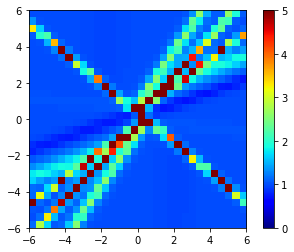

In [13]:
imshow( jacVals,
        extent = (-6, 6, -6, 6),
            origin='lower',cmap='jet', vmin=0,vmax=5)
colorbar()




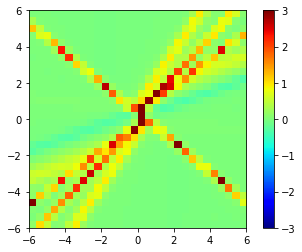

In [14]:
figure()
imshow( np.log(jacVals),
        extent = (-6, 6, -6, 6),
            origin='lower',cmap='jet', vmin=-3,vmax=3)
colorbar()

(-6.0, 6.0, -6.0, 6.0)

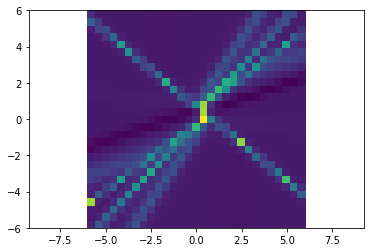

In [15]:
XX,YY = meshgrid(linspace(-6,6,30),linspace(-6,6,30))
pcolormesh(XX,YY,np.log(jacVals))
axis('equal')


In [18]:
flowFcn = lambda x: sess.run(z_k, feed_dict={Z: x})
domainRange = [(-6,6),(-6,6)]
gridSize = [20,20]
numPoints = 100
deformationGrid(flowFcn, domainRange, gridSize, numPoints,experiment.experiment_dir)        

In [17]:
help(deformationGrid)

Help on function deformationGrid in module utils:

deformationGrid(flowFcn, domainRange, gridSize, numPoints, directory)
    flowFcn : flow function
    gridSize : size of the grid, it is a list
    domainRange: it is a list of tuples specifying the range of the domain
    numPoints : density of points in each line



In [21]:
        
flowFcn = lambda x: sess.run(z_k, feed_dict={Z: x})
domainRange = [(-6,6,10),(-6,6,10)]
visualizeRange = [(-10,10),(-10,10)]
displacementField(flowFcn,domainRange,visualizeRange, experiment.experiment_dir)

In [20]:
help(displacementField)

Help on function displacementField in module utils:

displacementField(flowFcn, domainRange, visualizeRange, directory, title=None)
    flowFcn : flow function
    domainRange: it is a list of tuples specifying the range of the domain (the same as linspace)
    visualizeRange : list of tuples specifying the range of visualization



In [22]:
experiment.experiment_dir

'./experiments/40|temp|resnet|4|10000|0.01'